## Question 4: Clustering - CBC News Coronavirus articles
- Build a clustering model to cluster the articles in cbc-news-coronavirus-articles- march-26 dataset (news.csv). Explain the main characteristics of each cluster. Use Word Cloud to visualize each cluster. (Hint: Use feature description and/or text)
- Read more information here:
https://www.kaggle.com/ryanxjhan/cbc-news-coronavirus-articles-march-26

# 0.Working environment preparation & Package import

In [1]:
# !apt-get update

In [2]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
# !tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
# !pip install -q findspark
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [4]:
# %cd "/content/gdrive/MyDrive/LDS9_K272_ONLINE_DamThiMinhPhuong/LDS9_K272_DamThiMinhPhuong_Cuoi_ky"

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [3]:
spark = SparkSession.builder.appName('Q3_regression').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/26 21:48:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1. Dataset understanding

In [4]:
# Load data using pandas
df = pd.read_csv('data/cbc-news-coronavirus-articles-march-26/news.csv', index_col=0)

In [5]:
df.head()

,authors,title,publish_date,description,text,url
0,['Cbc News'],Coronavirus a 'wake-up call' for Canada's pres...,2020-03-27 08:00:00,Canadian pharmacies are limiting how much medi...,Canadian pharmacies are limiting how much medi...,https://www.cbc.ca/news/health/covid-19-drug-s...
1,['Cbc News'],Yukon gov't names 2 possible sources of corona...,2020-03-27 01:45:00,The Yukon government has identified two places...,The Yukon government has identified two places...,https://www.cbc.ca/news/canada/north/yukon-cor...
2,['The Associated Press'],U.S. Senate passes $2T coronavirus relief package,2020-03-26 05:13:00,The Senate has passed an unparalleled $2.2 tri...,The Senate late Wednesday passed an unparallel...,https://www.cbc.ca/news/world/senate-coronavir...
3,['Cbc News'],Coronavirus: The latest in drug treatment and ...,2020-03-27 00:36:00,Scientists around the world are racing to find...,Scientists around the world are racing to find...,https://www.cbc.ca/news/health/coronavirus-tre...
4,['Cbc News'],The latest on the coronavirus outbreak for Mar...,2020-03-26 20:57:00,The latest on the coronavirus outbreak from CB...,Trudeau says rules of Quarantine Act will ...,https://www.cbc.ca/news/the-latest-on-the-coro...


In [6]:
df_sub = df[['description','text']]

In [7]:
# convert pandas dataframe to pyspark dataframe
df_schema = StructType([
                        StructField("description", StringType(), True),
                        StructField("text", StringType(), True)
                       ])
data = spark.createDataFrame(df_sub, schema=df_schema)

In [8]:
data.count()

22/01/26 21:48:16 WARN TaskSetManager: Stage 0 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


3566

In [9]:
data.printSchema()

root
 |-- description: string (nullable = true)
 |-- text: string (nullable = true)



In [10]:
data.show(3)

+--------------------+--------------------+
|         description|                text|
+--------------------+--------------------+
|Canadian pharmaci...|Canadian pharmaci...|
|The Yukon governm...|The Yukon governm...|
|The Senate has pa...|The Senate late W...|
+--------------------+--------------------+
only showing top 3 rows



22/01/26 21:48:19 WARN TaskSetManager: Stage 3 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


In [11]:
# Combine 2 column: 'description' & "text"
data = data.select(concat(col('description'),lit(' '),col("text")).alias('article'))

In [12]:
data.head(1)

22/01/26 21:48:25 WARN TaskSetManager: Stage 4 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


[Row(article='Canadian pharmacies are limiting how much medication can be dispensed to try to prevent shortages, recognizing that most active ingredients for drugs come from India and China and medical supply chains have been disrupted by the spread of COVID-19. Canadian pharmacies are limiting how much medication can be dispensed to try to prevent shortages, recognizing that most active ingredients for drugs come from India and China and medical supply chains have been disrupted by the spread of COVID-19. Provincial regulatory colleges are complying with the Canadian Pharmacists Association call to limit the amount of medications given to patients to 30-day\xa0supplies. The goal is to stop people from refilling prescriptions early and to ensure life-saving drugs don\'t run short when supply chains are\xa0vulnerable. Mina Tadrous is a pharmacist and researcher in Toronto who monitors pharmaceutical supplies. He is worried Canadians will start stockpiling drugs after watching what has b

In [13]:
# Check null values
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas()

22/01/26 21:48:29 WARN TaskSetManager: Stage 5 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


,article
0,0


In [14]:
# Check NaN values
data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).toPandas()

22/01/26 21:48:30 WARN TaskSetManager: Stage 8 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


,article
0,0


In [15]:
# Check duplicates
dup_rows = data.count() - data.distinct().count()
dup_rows

22/01/26 21:48:31 WARN TaskSetManager: Stage 11 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/26 21:48:32 WARN TaskSetManager: Stage 14 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


811

In [20]:
# Drop duplicates
data = data.drop_duplicates()
data.count()

22/01/25 18:19:43 WARN TaskSetManager: Stage 4 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


2755

In [21]:
# Clean special characters
data = data.withColumn('clean_article', (lower(regexp_replace('article', "[^a-zA-Z\\s]", " "))))

In [22]:
data = data.select('clean_article')
data.head(1)

22/01/25 18:19:45 WARN TaskSetManager: Stage 10 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


[Row(clean_article='the thames valley district school board has cancelled all school trips to mainland europe in march in response to the worldwide coronavirus outbreak  cbc news has learned  the thames valley district school board  tvdsb  has cancelled eight school trips to mainland europe scheduled for march break in response to the worldwide coronavirus outbreak  cbc news has learned   doriana rosati  the board s system principal responsible for field trips  said the decision was made in light of the growing number of confirmed covid    cases worldwide    in looking at the escalating numbers of the outbreak      it s grown into france  italy and spain and those are locations where are kids were scheduled to be going and we just can t risk our children s health or staff or volunteers   she said   in an interview with cbc s afternoon drive on tuesday  rosati said the cancellations will affect     students  staff and chaperones   a trip to ireland for    students slated to depart next 

In [23]:
# Tokenize
tokenizer = RegexTokenizer(inputCol='clean_article', outputCol='token_article')
tokenized_data = tokenizer.transform(data)

In [24]:
tokenized_data.select('token_article').show(3, False)

22/01/25 18:19:46 WARN TaskSetManager: Stage 13 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
# Remove stopwords
import requests
stopwords_list1 = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords_list1 = list(set(stopwords_list1.decode().splitlines()))
stopwords_list2 = ["s","said","will", 'corona','covid','virus','coronavirus','cbc','news','people','time']
stopword_list = stopwords_list1 + stopwords_list2
# stopword_list

stopremove = StopWordsRemover(inputCol='token_article', outputCol='stop_token', stopWords=stopword_list)
stopremoved_data = stopremove.transform(tokenized_data)

22/01/25 18:19:48 WARN StopWordsRemover: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [26]:
stopremoved_data.select('stop_token').show(3, False)

22/01/25 18:19:49 WARN TaskSetManager: Stage 16 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
# Filter words which have more than 2 letters
filter_length_udf = udf(lambda row: [x for x in row if len(x) > 2], ArrayType(StringType()))
filtered_data = stopremoved_data.withColumn('words_filtered', filter_length_udf(col('stop_token')))

In [28]:
filtered_data.select('words_filtered').show(1, False)

22/01/25 18:19:50 WARN TaskSetManager: Stage 19 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Traceback (most recent call last):
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [29]:
# CountVectorize 
count_vec = CountVectorizer(inputCol='words_filtered', outputCol='c_vec')
cv_model = count_vec.fit(filtered_data)
cv_data = cv_model.transform(filtered_data)

22/01/25 18:19:51 WARN TaskSetManager: Stage 22 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


In [30]:
cv_data.select('c_vec').show(1, False)

22/01/25 18:19:57 WARN TaskSetManager: Stage 29 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|c_vec                                                                            

In [31]:
# TF-IDF
idf = IDF(inputCol='c_vec', outputCol='tf_idf')
idf_model = idf.fit(cv_data)
idf_data = idf_model.transform(cv_data)

22/01/25 18:19:59 WARN TaskSetManager: Stage 32 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


In [32]:
idf_data.select('tf_idf').show(1,False)

22/01/25 18:20:02 WARN TaskSetManager: Stage 36 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [33]:
# Format the data
clean_up = VectorAssembler(inputCols=['tf_idf'], 
                           outputCol='features')

In [34]:
cleaner = clean_up.transform(idf_data)

In [35]:
cleaner.show(3)

22/01/25 18:20:03 WARN TaskSetManager: Stage 39 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|       clean_article|       token_article|          stop_token|      words_filtered|               c_vec|              tf_idf|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|the thames valley...|[the, thames, val...|[thames, valley, ...|[thames, valley, ...|(33484,[0,1,2,7,8...|(33484,[0,1,2,7,8...|(33484,[0,1,2,7,8...|
|seven more people...|[seven, more, peo...|[tested, positive...|[tested, positive...|(33484,[0,1,2,3,6...|(33484,[0,1,2,3,6...|(33484,[0,1,2,3,6...|
|another    people...|[another, people,...|[tested, week, pa...|[tested, week, pa...|(33484,[0,1,2,3,4...|(33484,[0,1,2,3,4...|(33484,[0,1,2,3,4...|
+--------------------+--------------------+--------------------+--------------------+--------------------+

Traceback (most recent call last):
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [36]:
final_data = cleaner.select('features')
final_data.show(3)

22/01/25 18:20:05 WARN TaskSetManager: Stage 42 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+
|            features|
+--------------------+
|(33484,[0,1,2,7,8...|
|(33484,[0,1,2,3,6...|
|(33484,[0,1,2,3,4...|
+--------------------+
only showing top 3 rows



Traceback (most recent call last):
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [37]:
# Find k
k_list = []
silhouette_list = []
sil_str=''

for k in range(2,11):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(final_data)
    
    #silhouette
    k_list.append(k)
    predictions = model.transform(final_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)
    sil_str = sil_str + 'With k' + str(k) + '- Silhouette = ' + str(silhouette) + '\n'

22/01/25 18:20:05 WARN TaskSetManager: Stage 45 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:20:06 WARN TaskSetManager: Stage 46 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:20:07 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:20:10 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:20:11 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:20:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:20:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:20:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:20:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:20:13 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIB

22/01/25 18:20:55 WARN TaskSetManager: Stage 267 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:20:55 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:20:57 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:20:57 WARN TaskSetManager: Stage 273 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:20:57 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/01/25 18:20:59 WARN TaskSetManager: Stage 277 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:21:00 WARN DAGScheduler: Broadcasting large task binary with size 2027.1 KiB
22/01/25 18:21:01 WARN TaskSetManager: Stage 283 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:21:02 WARN DAGScheduler: Broadcasting large task binary with size 2.7

22/01/25 18:21:41 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:21:41 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:21:41 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:21:42 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:21:42 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:21:42 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:21:43 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:21:43 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:21:43 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:21:44 WARN TaskSetManager: Stage 551 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:21:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 M

22/01/25 18:22:28 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:22:29 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:22:29 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:22:29 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:22:30 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:22:30 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:22:30 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:22:30 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:22:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:22:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:22:32 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:22:32 WARN DAGScheduler: Broadcasting larg

In [63]:
print(sil_str)

With k2- Silhouette = 0.17038609181927775
With k3- Silhouette = 0.18010732886486663
With k4- Silhouette = 0.22105380592246268
With k5- Silhouette = 0.12786912490511645
With k6- Silhouette = 0.042673960189535565
With k7- Silhouette = -0.18165933820650357
With k8- Silhouette = 0.008179064745753412
With k9- Silhouette = 0.005008758913658326
With k10- Silhouette = 0.02982262890176059



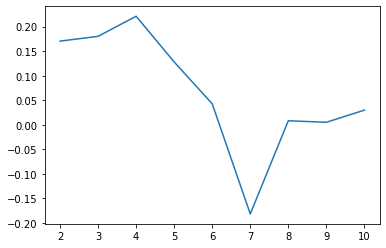

In [64]:
plt.plot(k_list, silhouette_list)
plt.show()

In [65]:
# Choose k=4 (the highest value of Silhouette)
kmeans = KMeans(featuresCol='features', k=4)
model = kmeans.fit(final_data)

22/01/25 18:24:03 WARN TaskSetManager: Stage 1073 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:24:04 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:24:06 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:24:06 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:24:06 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:24:07 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:24:07 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:24:08 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:24:08 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:24:08 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/01/25 18:24:08 WARN DAGScheduler: Broadcasting large task binary with size 2.7 

In [66]:
# Silhouette
predictions = model.transform(final_data)
# Evaluate
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print( 'Silhouette = '+ str(silhouette))

22/01/25 18:24:16 WARN TaskSetManager: Stage 1155 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:24:17 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/01/25 18:24:18 WARN TaskSetManager: Stage 1159 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:24:19 WARN DAGScheduler: Broadcasting large task binary with size 2027.1 KiB


Silhouette = 0.22105380592246268


In [67]:
# results
centers = model.clusterCenters()
print('Cluster centers:')
for center in centers:
    print(center)

Cluster centers:
[0.88693523 0.95013252 0.81934063 ... 0.         0.00330516 0.        ]
[1.67945832 1.76784703 2.37764993 ... 0.01541234 0.         0.01541234]
[ 3.56124593 10.76332572  4.35259923 ...  0.          0.
  0.        ]
[1.34188176 0.72475547 1.88500448 ... 0.         0.         0.        ]


In [68]:
predictions.select('prediction').show(5)

22/01/25 18:24:20 WARN TaskSetManager: Stage 1165 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.


+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 5 rows



22/01/25 18:24:20 WARN DAGScheduler: Broadcasting large task binary with size 2005.4 KiB
Traceback (most recent call last):
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Users/elliedam/spark/spark-3.2.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [69]:
predictions.groupBy('prediction').count().show()

22/01/25 18:24:21 WARN TaskSetManager: Stage 1168 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:24:21 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+----------+-----+
|prediction|count|
+----------+-----+
|         1|  465|
|         3|   26|
|         2|   73|
|         0| 2191|
+----------+-----+



22/01/25 18:24:23 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


In [70]:
predictions.columns

['features', 'prediction']

In [71]:
cleaner.columns

['clean_article',
 'token_article',
 'stop_token',
 'words_filtered',
 'c_vec',
 'tf_idf',
 'features']

In [72]:
# Combine 2 df: predictions & filtered_data
predictions = predictions.withColumn('row_index', monotonically_increasing_id())
filtered_data = filtered_data.withColumn('row_index', monotonically_increasing_id())

data_prediction = filtered_data.join(predictions, on=['row_index']).sort('row_index').drop('row_index')

In [73]:
data_prediction.columns

['clean_article',
 'token_article',
 'stop_token',
 'words_filtered',
 'features',
 'prediction']

In [74]:
data_prediction = data_prediction.select('words_filtered', 'prediction')

In [75]:
data_prediction = data_prediction.withColumn("words_filtered",concat_ws(" ",col("words_filtered")))
data_prediction.show(3)

22/01/25 18:39:15 WARN TaskSetManager: Stage 1174 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:39:15 WARN DAGScheduler: Broadcasting large task binary with size 2006.4 KiB


+--------------------+----------+
|      words_filtered|prediction|
+--------------------+----------+
|thames valley dis...|         0|
|tested positive i...|         0|
|tested week param...|         0|
+--------------------+----------+
only showing top 3 rows



In [76]:
# combine rows which have similar prediction
grouped_data = data_prediction.groupBy('prediction').agg(collect_list('words_filtered').alias("words_filtered"))
grouped_data.show(3)

22/01/25 18:39:19 WARN TaskSetManager: Stage 1179 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:39:19 WARN DAGScheduler: Broadcasting large task binary with size 2006.4 KiB
22/01/25 18:39:22 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:39:23 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:39:23 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+----------+--------------------+
|prediction|      words_filtered|
+----------+--------------------+
|         1|[scientists racin...|
|         3|[fear catching le...|
|         2|[parts continue r...|
+----------+--------------------+
only showing top 3 rows



In [77]:
grouped_data = grouped_data.withColumn("cluster_article", concat_ws(" ", "words_filtered"))
grouped_data.show(3)

22/01/25 18:39:27 WARN TaskSetManager: Stage 1197 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:39:27 WARN DAGScheduler: Broadcasting large task binary with size 2006.4 KiB
22/01/25 18:39:31 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:39:31 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:39:31 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+----------+--------------------+--------------------+
|prediction|      words_filtered|     cluster_article|
+----------+--------------------+--------------------+
|         1|[scientists racin...|scientists racing...|
|         3|[fear catching le...|fear catching led...|
|         2|[parts continue r...|parts continue ra...|
+----------+--------------------+--------------------+
only showing top 3 rows



In [78]:
cluster_data = grouped_data.select('cluster_article','prediction')
cluster_data.show(3)

22/01/25 18:39:50 WARN TaskSetManager: Stage 1215 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:39:51 WARN DAGScheduler: Broadcasting large task binary with size 2006.4 KiB
22/01/25 18:39:54 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:39:55 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:39:55 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+--------------------+----------+
|     cluster_article|prediction|
+--------------------+----------+
|scientists racing...|         1|
|fear catching led...|         3|
|parts continue ra...|         2|
+--------------------+----------+
only showing top 3 rows



In [79]:
# Get cluster 0
cluster0 = cluster_data.filter('prediction==0').select('cluster_article')
cluster0.show(3)

22/01/25 18:39:58 WARN TaskSetManager: Stage 1233 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:39:58 WARN DAGScheduler: Broadcasting large task binary with size 2006.4 KiB
22/01/25 18:40:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:40:02 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:40:02 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+--------------------+
|     cluster_article|
+--------------------+
|thames valley dis...|
+--------------------+



In [80]:
# Get cluster 1
cluster1 = cluster_data.filter('prediction==1').select('cluster_article')
cluster1.show(3)

22/01/25 18:40:03 WARN TaskSetManager: Stage 1251 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:40:03 WARN DAGScheduler: Broadcasting large task binary with size 2006.4 KiB
22/01/25 18:40:06 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:40:06 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:40:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+--------------------+
|     cluster_article|
+--------------------+
|scientists racing...|
+--------------------+



In [81]:
# Get cluster 2
cluster2 = cluster_data.filter('prediction==2').select('cluster_article')
cluster2.show(3)

22/01/25 18:40:08 WARN TaskSetManager: Stage 1269 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:40:08 WARN DAGScheduler: Broadcasting large task binary with size 2006.4 KiB
22/01/25 18:40:10 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:40:12 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:40:12 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+--------------------+
|     cluster_article|
+--------------------+
|parts continue ra...|
+--------------------+



In [82]:
# Get cluster 3
cluster3 = cluster_data.filter('prediction==3').select('cluster_article')
cluster3.show(3)

22/01/25 18:40:17 WARN TaskSetManager: Stage 1287 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:40:18 WARN DAGScheduler: Broadcasting large task binary with size 2006.4 KiB
22/01/25 18:40:21 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:40:22 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+--------------------+
|     cluster_article|
+--------------------+
|fear catching led...|
+--------------------+



22/01/25 18:40:22 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


In [57]:
# Plot wordcloud
from wordcloud import WordCloud

In [83]:
# instantiate a word cloud object
wc0 = WordCloud(background_color='black', max_words=5000)
wc1 = WordCloud(background_color='black', max_words=5000)
wc2 = WordCloud(background_color='black', max_words=5000)
wc3 = WordCloud(background_color='black', max_words=5000)


# generate the word cloud
wc_0 = wc0.generate(cluster0.toPandas().loc[0,'cluster_article']);
wc_1 = wc1.generate(cluster1.toPandas().loc[0,'cluster_article']);
wc_2 = wc2.generate(cluster2.toPandas().loc[0,'cluster_article']);
wc_3 = wc3.generate(cluster3.toPandas().loc[0,'cluster_article']);

22/01/25 18:41:12 WARN TaskSetManager: Stage 1305 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:41:13 WARN DAGScheduler: Broadcasting large task binary with size 2006.4 KiB
22/01/25 18:41:17 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:41:17 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:41:20 WARN TaskSetManager: Stage 1319 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:41:21 WARN DAGScheduler: Broadcasting large task binary with size 2006.4 KiB
22/01/25 18:41:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:41:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/01/25 18:41:26 WARN TaskSetManager: Stage 1333 contains a task of very large size (2093 KiB). The maximum recommended task size is 1000 KiB.
22/01/25 18:41:27 WARN DAGScheduler: Broadcast

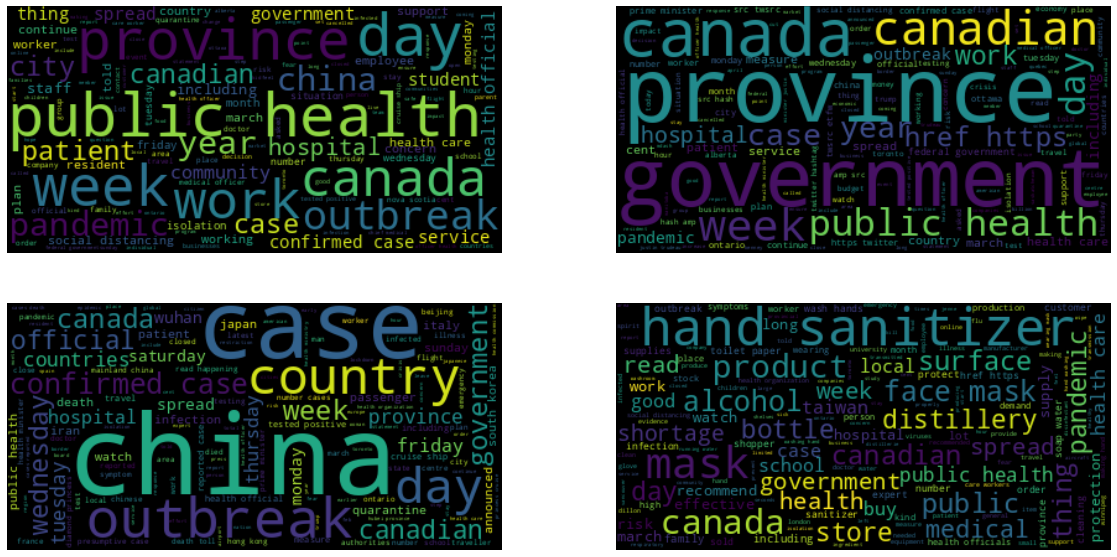

In [85]:
# display the word clouds
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.imshow(wc_0, interpolation='bilinear')
plt.axis('off')
plt.subplot(222)
plt.imshow(wc_1, interpolation='bilinear')
plt.axis('off')
plt.subplot(223)
plt.imshow(wc_2, interpolation='bilinear')
plt.axis('off')
plt.subplot(224)
plt.imshow(wc_3, interpolation='bilinear')
plt.axis('off')
plt.show()

In [86]:
# The most 5 frequent words
first_5_words_cluster0 = {k: wc_0.words_[k] for k in list(wc_0.words_)[:5]}
first_5_words_cluster0

{'public health': 1.0,
 'day': 0.9446583253128008,
 'province': 0.8830606352261791,
 'week': 0.8748796920115496,
 'work': 0.7670837343599615}

In [87]:
first_5_words_cluster1 = {k: wc_1.words_[k] for k in list(wc_1.words_)[:5]}
first_5_words_cluster1

{'province': 1.0,
 'government': 0.9865831842576028,
 'canada': 0.9838998211091234,
 'canadian': 0.9007155635062611,
 'week': 0.7942754919499105}

In [88]:
first_5_words_cluster2 = {k: wc_2.words_[k] for k in list(wc_2.words_)[:5]}
first_5_words_cluster2

{'china': 1.0,
 'case': 0.7057010785824345,
 'outbreak': 0.6687211093990755,
 'country': 0.5500770416024653,
 'day': 0.514637904468413}

In [89]:
first_5_words_cluster3 = {k: wc_3.words_[k] for k in list(wc_3.words_)[:5]}
first_5_words_cluster3

{'hand sanitizer': 1.0,
 'mask': 0.6781609195402298,
 'canada': 0.41954022988505746,
 'product': 0.367816091954023,
 'face mask': 0.28160919540229884}

In [91]:
df_first_5_words_cluster0 = pd.DataFrame(list(first_5_words_cluster0.items()),
                                     columns=['word','freq'])
df_first_5_words_cluster1 = pd.DataFrame(list(first_5_words_cluster1.items()),
                                     columns=['word','freq'])
df_first_5_words_cluster2 = pd.DataFrame(list(first_5_words_cluster2.items()),
                                     columns=['word','freq'])
df_first_5_words_cluster3 = pd.DataFrame(list(first_5_words_cluster3.items()),
                                     columns=['word','freq'])

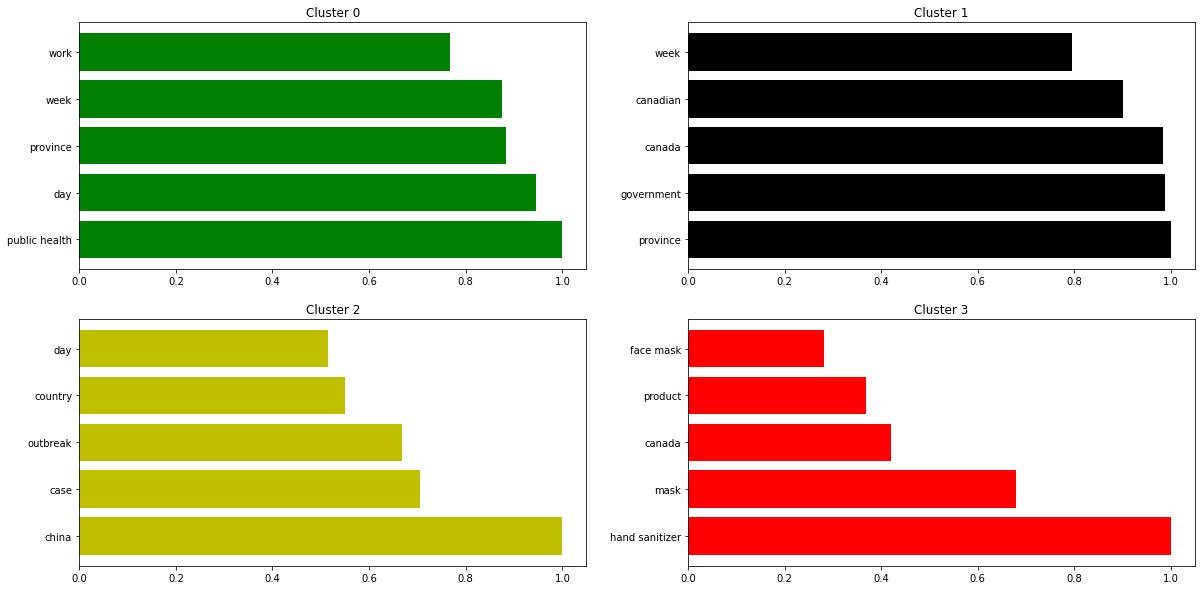

In [99]:
# Visualization
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.barh(df_first_5_words_cluster0.word, df_first_5_words_cluster0.freq, color='g')
plt.title('Cluster 0')
plt.subplot(222)
plt.barh(df_first_5_words_cluster1.word, df_first_5_words_cluster1.freq, color='black')
plt.title('Cluster 1')
plt.subplot(223)
plt.barh(df_first_5_words_cluster2.word, df_first_5_words_cluster2.freq, color='y')
plt.title('Cluster 2')
plt.subplot(224)
plt.barh(df_first_5_words_cluster3.word, df_first_5_words_cluster3.freq, color='r')
plt.title('Cluster 3')

plt.show()

### Nhận xét: 
- Dữ liệu được chia thành 4 nhóm, tuy nhiên số lượng của các nhóm không cân bằng nhau, hầu hết dữ liệu thuộc về cluster 0
- Từ wordcloud có thể thấy Cluster 0 và Cluster 1 khá tương đồng có thể gộp thành 1 
- Suggested topic:
    + Cluster 0 & 1: Các giải pháp của chính phủ để bảo vệ sức khoẻ cộng đồng cho người dân Canada trong đại dịch 
    + Cluster 2: Thông tin các ca nhiễm, tình hình dịch ở Trung Quốc
    + Cluster 3: Biện pháp tránh lây lan covid: sử dụng nước rửa tay, khẩu trang, cồn..